In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 

%matplotlib inline

# **Load Data**

In [74]:
data = pd.read_csv('conversion_data.csv')
print(data.head(), data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0 None


In [75]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


**Data Quality:**
1. There are no missing values.
2. Outilers exist in Age column. Needs to be checked with the distribution.



# **Explotary Data Analysis**

1. Check the distribution. (categorical and numerical features)
2. Remove Outliers
3. Correlation

## Distribution

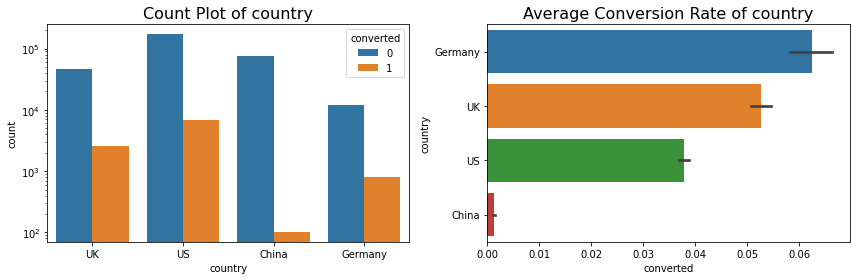

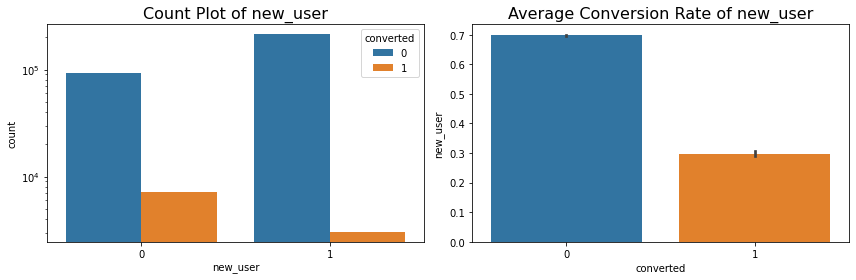

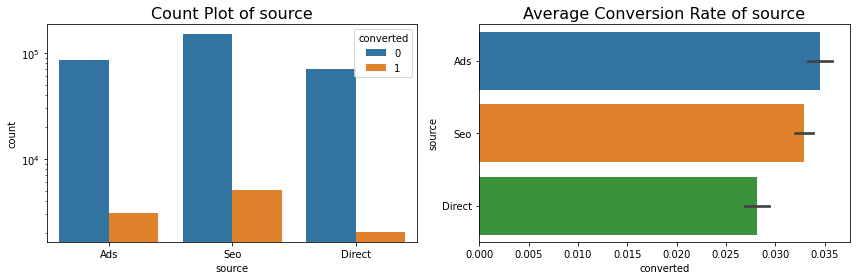

In [76]:
# categorical variables distribution
def categorical_dist(feature):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
  sns.countplot(x=feature, hue='converted', data=data, ax=ax[0])
  ax[0].set_title('Count Plot of'+ ' '+ feature, fontsize=16)
  ax[0].set_yscale("log")

  group = data.groupby(feature)['converted'].mean().reset_index().sort_values('converted', ascending=False)
  sns.barplot(x='converted', y=feature, data=data, ax=ax[1], order=group[feature])
  ax[1].set_title('Average Conversion Rate of' + ' '+ feature, fontsize=16)
  plt.tight_layout()
  plt.show()

categorical_dist('country')
categorical_dist('new_user')
categorical_dist('source')

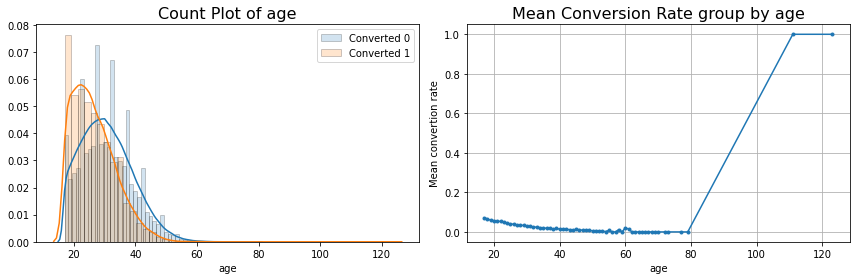

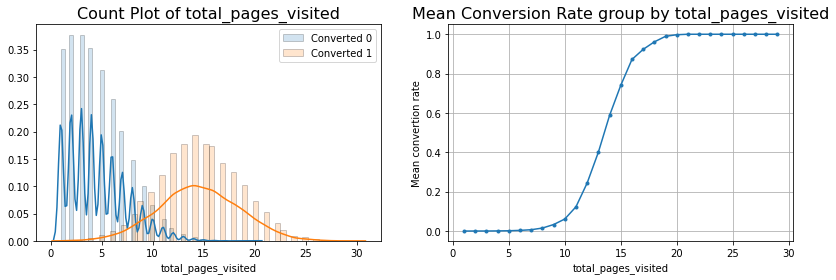

In [77]:
# Visualization of different sources
def numeric_dist(feature):    
  grouped = data[[feature, 'converted']].groupby(feature).mean().reset_index()
  hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
  sns.distplot(data[data['converted'] == 0][feature], label='Converted 0', ax=ax[0], hist_kws=hist_kws)
  sns.distplot(data[data['converted'] == 1][feature], label='Converted 1', ax=ax[0], hist_kws=hist_kws)
  ax[0].set_title('Count Plot of' + ' ' + feature, fontsize=16)
  ax[0].legend()

  ax[1].plot(grouped[feature], grouped['converted'], '.-')
  ax[1].set_title('Mean Conversion Rate group by' + ' ' + feature, fontsize=16)
  ax[1].set_xlabel(feature)
  ax[1].set_ylabel('Mean convertion rate')
  ax[1].grid(True)
  plt.tight_layout()
  plt.show()

numeric_dist('age')
numeric_dist('total_pages_visited')

**Conclusions for EDA:**

1. Customer demographic: 
a. country: The conusmers primarily come from US and China. Potential consumers from China show a low conversion rate.
b. age: Elder people with age greater than 80 has an abnormal value. With the age increases, the average conversion rate gets lower.

2. Customer attributes:
a. old/new user: It seems that new user acuqistion is good, but the conversion rate is low.
b. user source: Direct search has the lowest converstion rate.

3. Customer behavior:
Users who visit more pages tend to compelte purchase. People who did not purchase usually visit 1-6 pages while people who ordered usually visit 15 pages in average. 

## Remove Outliers

From the distributions I checked below, I will remove the users with age greater than 80. There seems 2 values greater than 80, which are 123 and 111 respectively. Removing 2 values is reasonable because it will not make us lose important and relevant information from dataset.

In [78]:
data = data[data['age'] < 80]

## Correlation

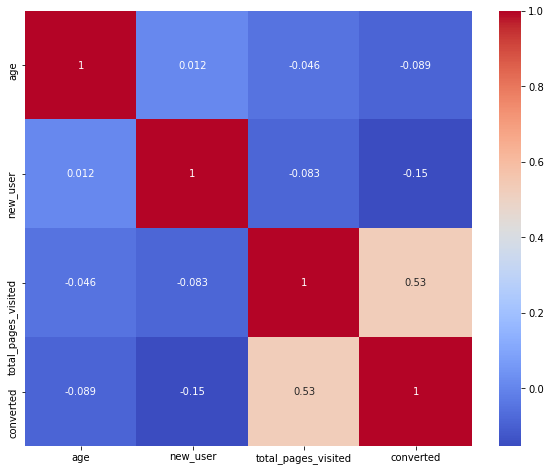

In [79]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

**Correlation check**
1. The number of pages visit realted positively most with conversion rate.
2. There is no relationship between variables.

# **Machine Learning**

Reasons for choosing Decision tree rather than Logistic Regression:
1. The dataset is highly skewed. Logistic Regression does not handle skewed data nicely. If we want to use Logistic Regression in this case, we need to give high weight to minority class.

other situation for choosing Decision tree:
2. Linearly non-sperable.
3. Categorical varibales. 
4. Outilers. Or remove outliers.
5. Lots of missing values.

In [80]:
# check skewness of class
data['converted'].mean()

0.03225194340255157

## Baseline - Decision Tree

In [81]:
data = pd.get_dummies(data, columns=['country', 'new_user', 'source'])

In [82]:
# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['converted'], axis=1), data['converted'], test_size = 0.3, random_state = 100)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91746
           1       0.86      0.63      0.73      3114

    accuracy                           0.98     94860
   macro avg       0.93      0.81      0.86     94860
weighted avg       0.98      0.98      0.98     94860

[[91438   308]
 [ 1159  1955]]


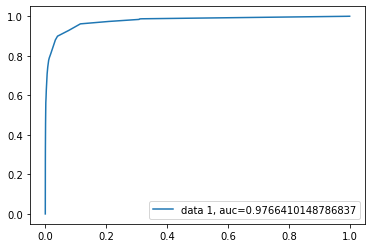

In [83]:
# decision tree fit
tree = DecisionTreeClassifier(random_state=0, max_depth=5)
tree.fit(X_train, y_train)
# prediction
predictions = tree.predict(X_test)
# evaluation
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

y_pred_proba = tree.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

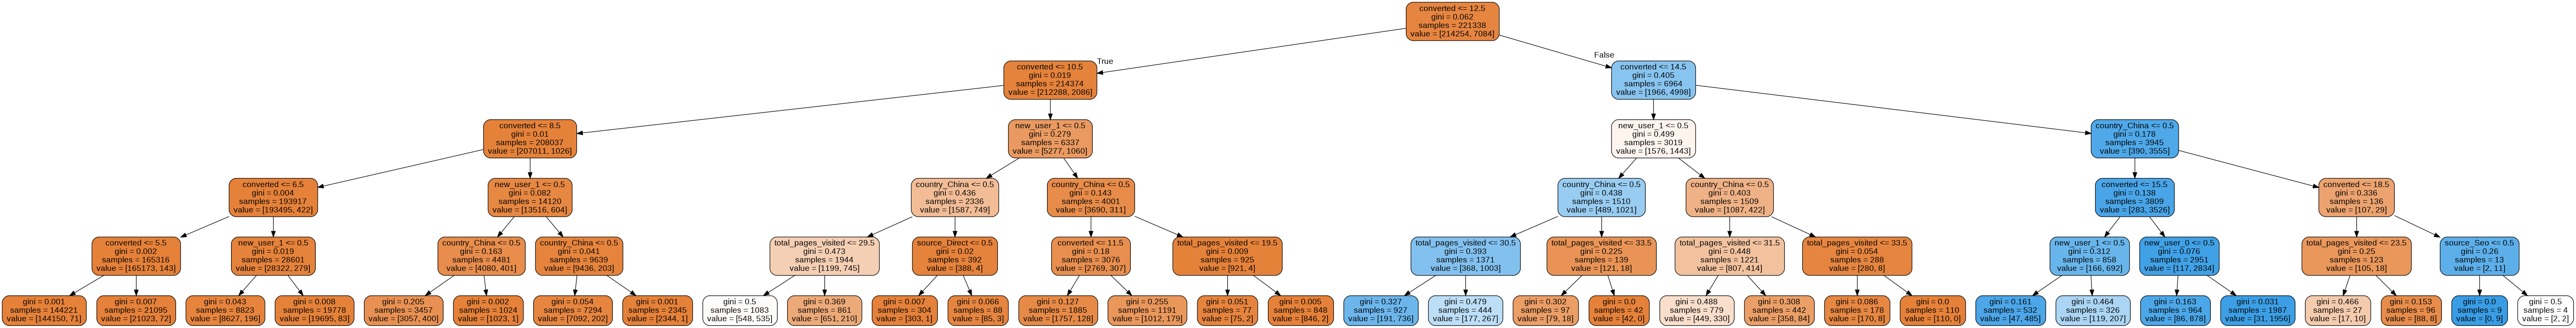

In [84]:
# decision tree visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(data.columns[1:])

dot_data = StringIO()  
export_graphviz(tree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=20)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))
print(confusion_matrix(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     91746
           1       0.81      0.67      0.73      3114

    accuracy                           0.98     94860
   macro avg       0.90      0.83      0.86     94860
weighted avg       0.98      0.98      0.98     94860

[[91259   487]
 [ 1036  2078]]


## Machine Learning Insights

In [86]:
# permutation importance
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(tree, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0332 ± 0.0005,total_pages_visited
0.0041 ± 0.0003,country_China
0.0028 ± 0.0004,new_user_1
0.0000 ± 0.0000,source_Seo
0 ± 0.0000,source_Direct
0 ± 0.0000,source_Ads
0 ± 0.0000,new_user_0
0 ± 0.0000,country_US
0 ± 0.0000,country_UK
0 ± 0.0000,country_Germany


In [87]:
# partial dependence plots
from matplotlib import pyplot as plt
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

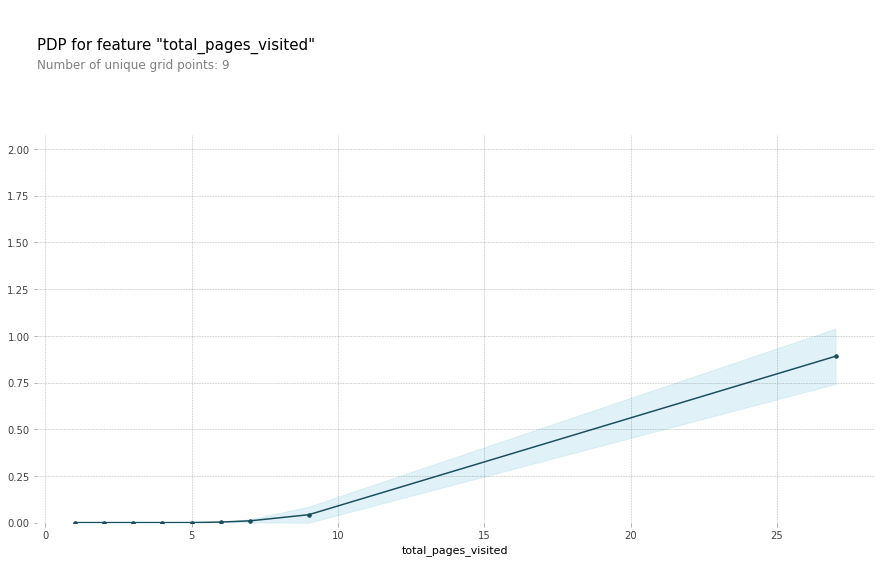

<Figure size 576x360 with 0 Axes>

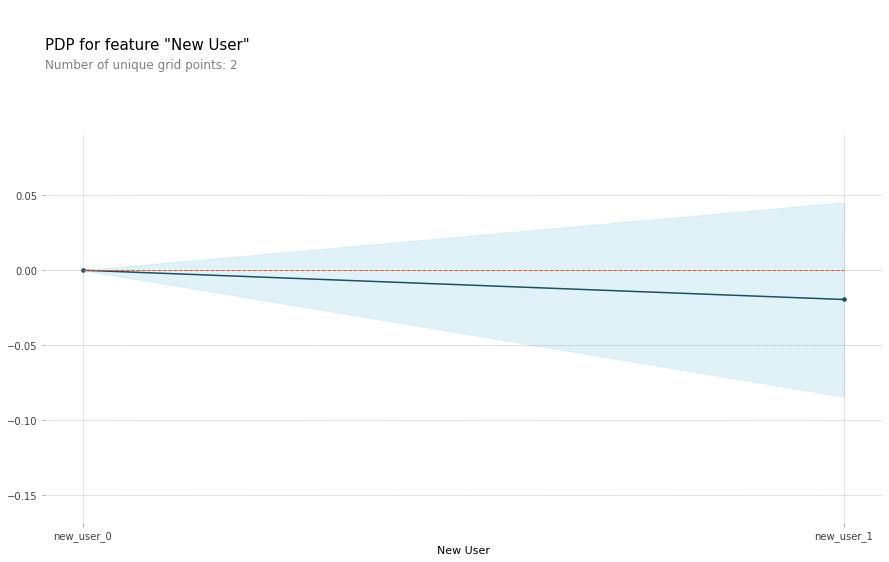

<Figure size 576x360 with 0 Axes>

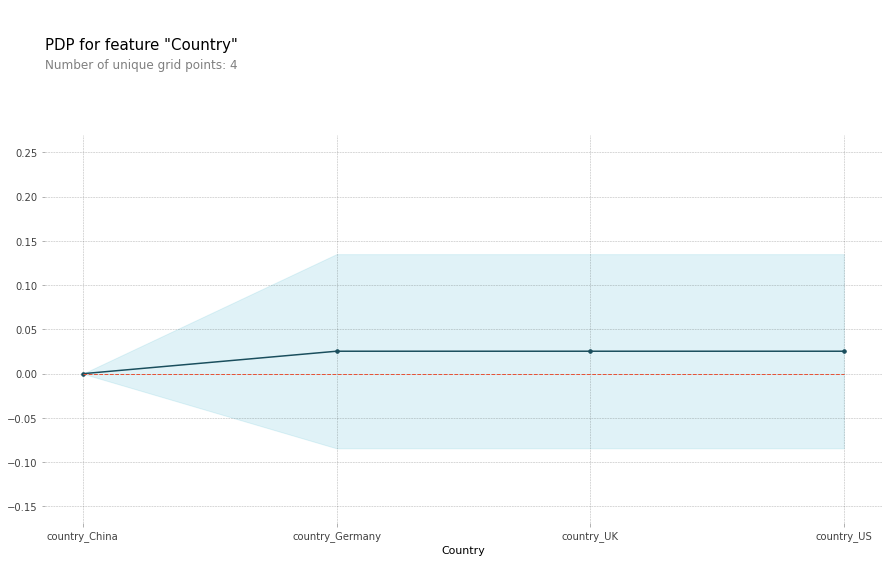

<Figure size 576x360 with 0 Axes>

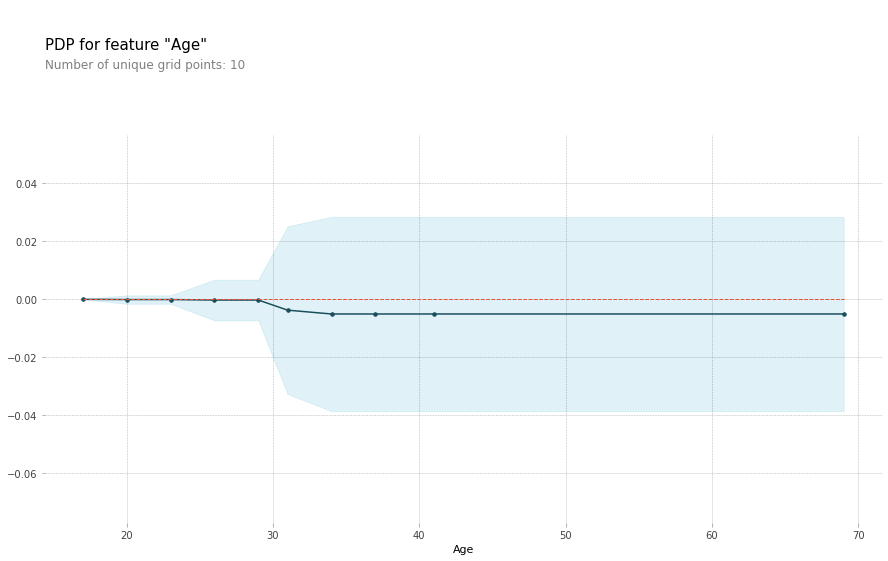

In [88]:
pdp_totalpagevisited = pdp.pdp_isolate(model=tree, dataset=X_test, model_features=X_test.columns.tolist(), feature='total_pages_visited')
pdp.pdp_plot(pdp_totalpagevisited, 'total_pages_visited')
plt.show()

plt.figure(figsize=(8,5))
pdp_newuser = pdp.pdp_isolate(model=tree, dataset=X_test, model_features=X_test.columns.tolist(), feature=['new_user_0', 'new_user_1'])
pdp.pdp_plot(pdp_newuser, 'New User')
plt.show()

plt.figure(figsize=(8,5))
pdp_country = pdp.pdp_isolate(model=tree, dataset=X_test, model_features=X_test.columns.tolist(), feature=['country_China', 'country_Germany', 'country_UK', 'country_US'])
pdp.pdp_plot(pdp_country, 'Country')
plt.show()

plt.figure(figsize=(8,5))
pdp_age = pdp.pdp_isolate(model=tree, dataset=X_test, model_features=X_test.columns.tolist(), feature='age')
pdp.pdp_plot(pdp_age, 'Age')
plt.show()

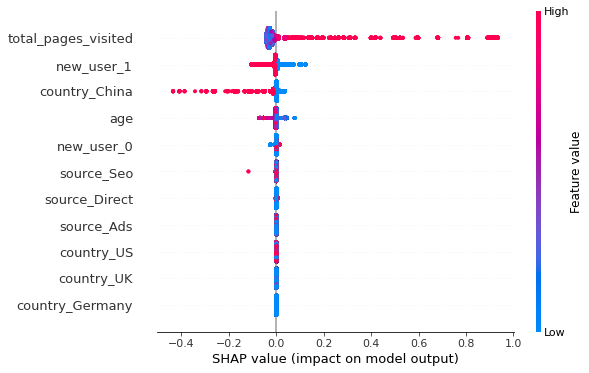

In [89]:
# shap value
!pip install shap
import shap
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

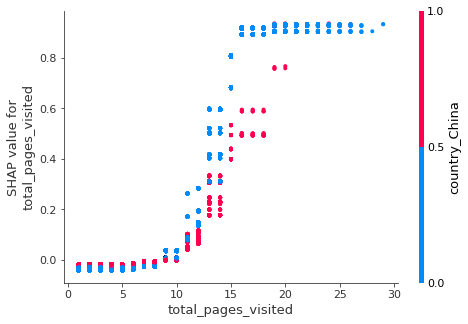

In [90]:
shap_values2 = explainer.shap_values(data.drop(['converted'], axis=1))
shap.dependence_plot('total_pages_visited', shap_values2[1], data.drop(['converted'], axis=1), interaction_index="country_China")